In [5]:
import gensim
import nltk
from gensim import corpora
from gensim.models import LdaModel
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from nltk.corpus import wordnet
import json

In [6]:
with open("chunk_1.json", "r") as file:
    chunk_1 = [json.loads(line) for line in file]


nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/anna/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/anna/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [9]:


def is_meaningful_word(word):
    """Check if the word has meaning using WordNet."""
    return wordnet.synsets(word)  # Returns True if the word has synsets (is meaningful)

def preprocess(text, stop_words):
    """
    Tokenizes and preprocesses the input text, removing stopwords and short tokens.

    Parameters:
        text (str): The input text to preprocess.
        stop_words (set): A set of stopwords to be removed from the text.
    Returns:
        list: A list of preprocessed tokens.
    """
    if not text:
        raise ValueError("Input text is empty or invalid.")

    result = []
    for token in simple_preprocess(text, deacc=True):
        if token not in stop_words and is_meaningful_word(token) and len(token) > 3:
            result.append(token)
    return result


def extract_topics(text, num_topics=2, num_words=2, passes=15):
    """
    Extracts topics from the input text using LDA and visualizes them with pyLDAvis.

    Parameters:
        text (str): The input text to extract topics from.
        num_topics (int): The number of topics to extract.
        num_words (int): The number of words to display for each topic.
        passes (int): The number of passes for LDA training.
    Returns:
        list: A list of tuples containing the topic keywords and their weights.
    """
    if not text:
        raise ValueError("Input text is empty or invalid.")

    stop_words = set(stopwords.words('english'))

 
    tokens = preprocess(text, stop_words)
    if not tokens:
        raise ValueError("Preprocessing resulted in no valid tokens. Check your text input.")

 
    dictionary = corpora.Dictionary([tokens])
    corpus = [dictionary.doc2bow(tokens)]


    lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=passes)

 
    topics = lda_model.print_topics(num_topics=num_topics, num_words=num_words)
    print("Extracted Topics:")
  
    for topic_num, topic in enumerate(topics, 1):
       
        print(f"Topic {topic_num}: {topic}")

   
    return topics

In [10]:
import csv

output_data = {}
distinct_topics = set()  

def parse_topics(topics):
    """
    Parse les topics pour extraire uniquement les mots associés, en supprimant les IDs et les poids.
    """
    parsed_topics = []
    for topic in topics:
        if isinstance(topic, tuple) and len(topic) == 2:
            _, topic_str = topic
         
            words = [word.split('"')[1] for word in topic_str.split(" + ") if '"' in word]
            parsed_topic = " + ".join(words)
            parsed_topics.append(parsed_topic)
            distinct_topics.add(parsed_topic)  
    return list(set(parsed_topics))  

for i, element in enumerate(chunk_1):
    print(f"Analyse de l'élément {i + 1}...")
    sample_text = element.get("normalizedBody", "").strip()
    if not sample_text:
        print(f"L'élément {i + 1} n'a pas de champ 'body' ou est vide. Ignoré.")
        continue

    try:
        topics = extract_topics(sample_text, num_topics=2, num_words=1, passes=15)
        if topics:
            output_data[i] = {
                "author": element.get("author", ""),
                "subreddit": element.get("subreddit", ""),
                "subreddit_id": element.get("subreddit_id", ""),
                "topics": "; ".join(parse_topics(topics))
            }
    except ValueError as e:
        print(f"Erreur lors de l'analyse de l'élément {i + 1} : {e}")


output_file_csv = "extracted_topics.csv"
with open(output_file_csv, mode="w", newline="", encoding="utf-8") as csv_file:
    writer = csv.DictWriter(csv_file, fieldnames=["author", "subreddit", "subreddit_id", "topics"])
    writer.writeheader()
    writer.writerows(output_data.values())


output_file_txt = "distinct_topics.txt"
with open(output_file_txt, mode="w", encoding="utf-8") as txt_file:
    txt_file.write("\n".join(sorted(distinct_topics))) 

print(f"Les résultats ont été enregistrés dans le fichier {output_file_csv}.")
print(f"Les topics distincts ont été enregistrés dans le fichier {output_file_txt}.")


Analyse de l'élément 1...
Extracted Topics:
Topic 1: (0, '0.014*"timekeeping"')
Topic 2: (1, '0.037*"timekeeping"')
Analyse de l'élément 2...
Extracted Topics:
Topic 1: (0, '0.032*"term"')
Topic 2: (1, '0.020*"street"')
Analyse de l'élément 3...
Extracted Topics:
Topic 1: (0, '0.037*"street"')
Topic 2: (1, '0.018*"wall"')
Analyse de l'élément 4...
Extracted Topics:
Topic 1: (0, '0.012*"cover"')
Topic 2: (1, '0.024*"plus"')
Analyse de l'élément 5...
Extracted Topics:
Topic 1: (0, '0.011*"item"')
Topic 2: (1, '0.066*"item"')
Analyse de l'élément 6...
Extracted Topics:
Topic 1: (0, '0.023*"nail"')
Topic 2: (1, '0.062*"nail"')
Analyse de l'élément 7...
Extracted Topics:
Topic 1: (0, '0.045*"directions"')
Topic 2: (1, '0.018*"maps"')
Analyse de l'élément 8...
Extracted Topics:
Topic 1: (0, '0.020*"mind"')
Topic 2: (1, '0.031*"back"')
Analyse de l'élément 9...
Extracted Topics:
Topic 1: (0, '0.018*"concern"')
Topic 2: (1, '0.030*"concern"')
Analyse de l'élément 10...
Extracted Topics:
Topic 

KeyboardInterrupt: 

In [11]:
from transformers import BertTokenizer, BertModel
import torch


tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")
model = BertModel.from_pretrained("bert-base-multilingual-cased")


with open("distinct_topics.txt", "r", encoding="utf-8") as file:
    words = [line.strip() for line in file]


embeddings = []
for word in words:
    inputs = tokenizer(word, return_tensors="pt", truncation=True)
    outputs = model(**inputs)
    # Utilisez la dernière couche cachée moyenne comme embedding
    embedding = outputs.last_hidden_state.mean(dim=1).detach().numpy()
    embeddings.append(embedding)


In [13]:
from sklearn.cluster import KMeans
import numpy as np
import json

# Assurez-vous que `embeddings` et `words` sont définis avant d'exécuter ce code.
embedding_matrix = np.vstack(embeddings)

num_clusters = 100
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(embedding_matrix)

clusters = kmeans.labels_

# Regrouper les mots par cluster
grouped_words = {i: [] for i in range(num_clusters)}
for word, cluster_id in zip(words, clusters):
    grouped_words[cluster_id].append(word)

# Sauvegarde des clusters dans un fichier JSON
output_file_json = "clusters.json"
with open(output_file_json, mode="w", encoding="utf-8") as json_file:
    json.dump(grouped_words, json_file, ensure_ascii=False, indent=4)

# Affichage des clusters dans la console
for cluster_id, cluster_words in grouped_words.items():
    print(f"Cluster {cluster_id}: {', '.join(cluster_words)}")



/home/anna/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster 0: asses, beans, beef, bees, bets, breed, centimeter, cheap, dame, fenders, flair, forehead, geek, geeks, halle, hamburg, heal, healer, heap, heist, hooded, horde, intuit, kind, klein, lender, loot, louis, maledict, mans, patrick, pennies, platoons, preschool, pretend, pretzel, priest, quints, redeemed, reed, reel, rent, righteous, rode, seem, spawn, spoons, stem, tent, tents, tweaks, want, ware, watt, watts, weeds, wees, wonder
Cluster 1: barbed, bear, bell, belt, bloodstone, boner, bubble, bucket, buffer, bulb, bullet, burn, burst, bush, busy, cabin, cataract, cavity, chester, coat, collar, crow, cute, cutler, cutter, flagpole, flat, flesh, flurry, golden, gopher, gorge, heckle, hustle, ironman, jerry, knock, lawn, leather, locksmith, lossy, mattress, orwell, outhouse, pebble, plumber, rabble, rainbow, ranger, rotary, rougher, rumble, rusher, rustler, sand, scout, shadow, shady, shake, shard, shaven, shoot, shovel, shut, sight, skull, slay, smith, snake, spell, spring, squat,

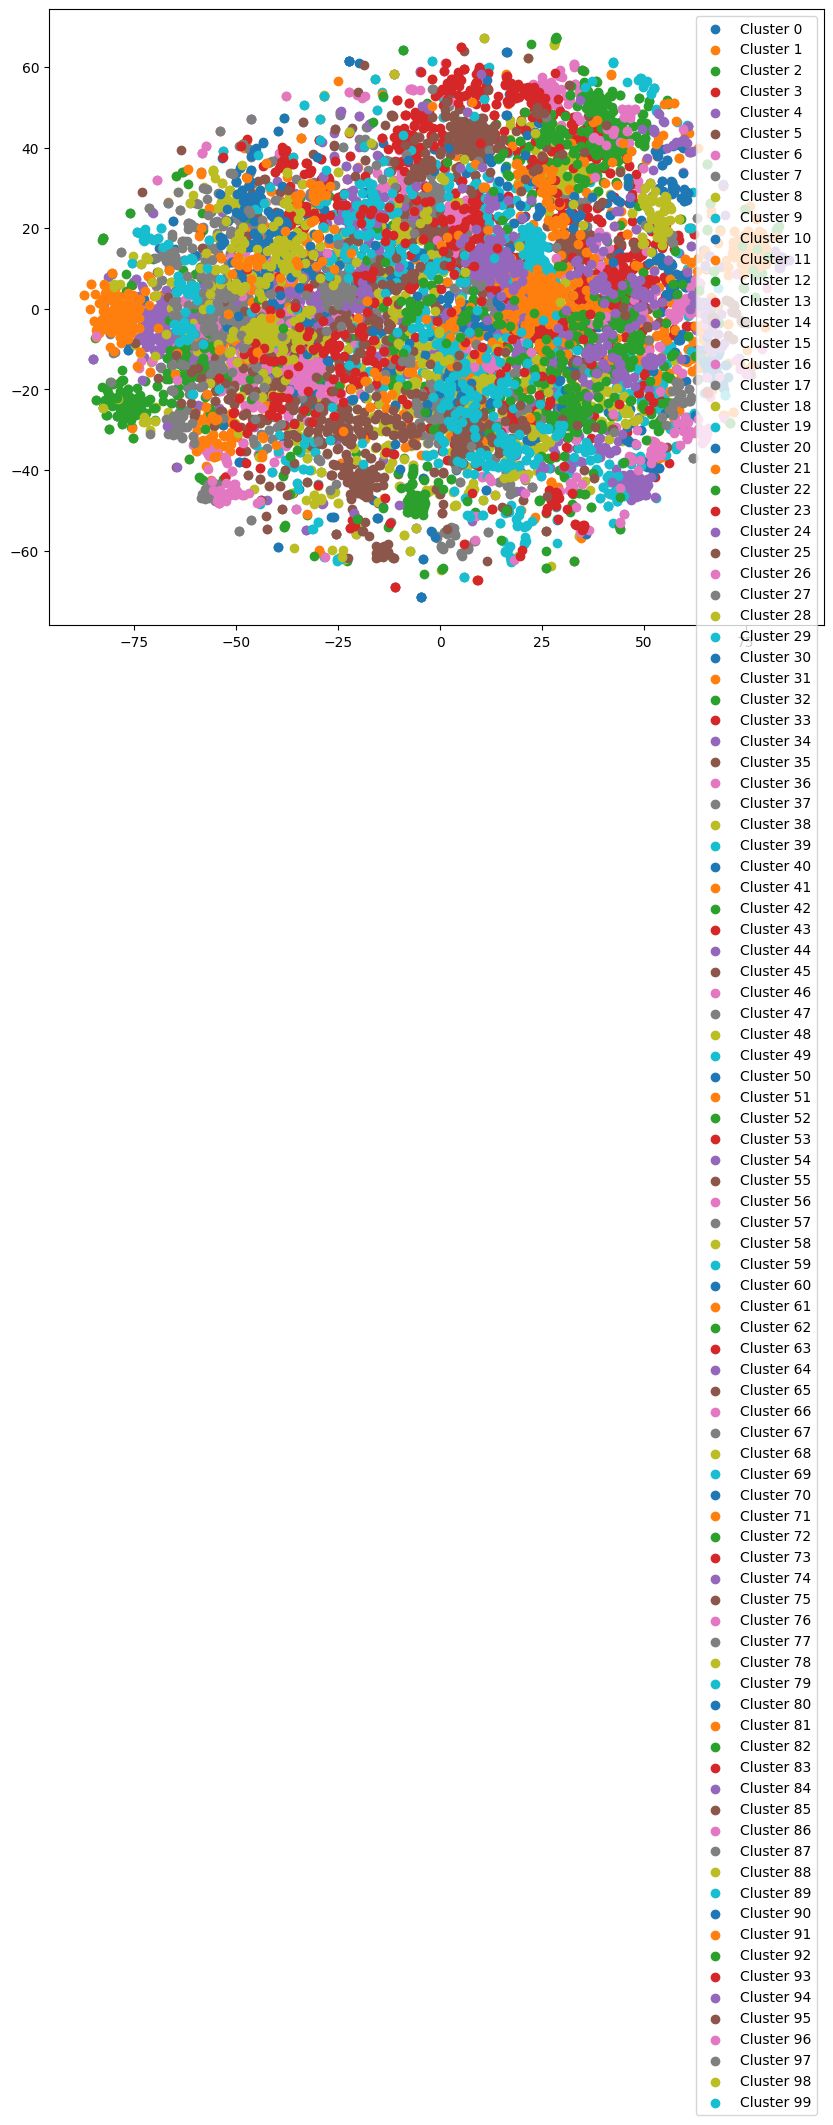

In [14]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(embedding_matrix)

plt.figure(figsize=(10, 8))
for cluster_id in range(num_clusters):
    cluster_points = reduced_embeddings[clusters == cluster_id]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster_id}")
plt.legend()
plt.show()


In [16]:
from transformers import BartForConditionalGeneration, BartTokenizer
from transformers.utils import hub

# Augmenter le délai d'attente pour les connexions
hub.constants.HF_HUB_DOWNLOAD_TIMEOUT = 60  # Temps en secondes

# Charger le modèle de résumé et le tokenizer
model_name = "facebook/bart-large-cnn"
tokenizer = BartTokenizer.from_pretrained(model_name)
model = BartForConditionalGeneration.from_pretrained(model_name)

# Exemple : Clusters de mots
clusters = grouped_words

# Résumer chaque cluster
cluster_summaries = {}
for cluster_id, words in clusters.items():
    # Transformer les mots du cluster en phrase
    input_text = ", ".join(words) + "."
    inputs = tokenizer(input_text, max_length=512, truncation=True, return_tensors="pt")
    
    # Générer un résumé
    summary_ids = model.generate(inputs["input_ids"], max_length=50, min_length=10, length_penalty=2.0, num_beams=4, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    
    cluster_summaries[cluster_id] = summary

# Afficher les résumés
for cluster_id, summary in cluster_summaries.items():
    print(f"Cluster {cluster_id}: {summary}")



model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

Cluster 0: asses, beans, beef, bees, bets, breed, centimeter, cheap, dame, fenders, flair, forehead, geek, geeks, halle, hamburg, heal, healer, heap, heist,
Cluster 1: Barbed, bear, bell, belt, bloodstone, boner, bubble, bucket, buffer, bulb, bullet, burn, burst, bush, busy, cabin, cataract, cavity, chester.
Cluster 2: aliens, americans, applies, arthropods, beers, beings, birds, birthdays, blacks, breasts, cardinals, casters, celebrities, centenarians, chiefs, clans, classics, clouds, colloids
Cluster 3: accessing, adapters, aids, algorithms, alliances, answers, applicants, applications, axioms, benchmarks, booths, browsers, builds, caches, cartridges, checks, choices, classmates, clicks, commandments, compressions, connector
Cluster 4: This is the first of a two-part series on the world of zoos. The second part of the series will be posted on Monday.
Cluster 5: abiogenesis, abortion, agnosticism, agoraphobia, amethyst, anarchists, anesthesia, anthropologists, aphorism, apocalypse, ap